<a href="https://colab.research.google.com/github/rajiv-ranjan/cds-mini-projects/blob/Archana/M2_NB_MiniProject_5_Customer_Segmentation_Kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Customer segmentation using clustering

## Learning Objectives

At the end of the experiment, you will be able to :

* extract summary level insight from a given customer dataset.

* handle the missing data and identify the underlying pattern or structure of the data.

* create an unsupervised model that generates the optimum number of segments for the customer base

* identify customer segments based on the overall buying behaviour


## Dataset

The dataset chosen for this mini project is the Online Retail dataset. It is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

The dataset contains 541909 records, and each record is made up of 8 fields.

To know more about the dataset : [click here](https://archive.ics.uci.edu/ml/datasets/Online+Retail)

## Information

**Clustering** is the task of grouping together a set of objects so that the objects in the same cluster are more similar to each other than to objects in other clusters. Similarity is a measure that reflects the strength of the relationship between two data objects.

In the clustering calculation, K-Means is a very popular algorithm. In this analysis, this method is used to cluster the similar data items.

In Retail and E-Commerce (B2C), and more broadly in B2B, one of the key elements shaping the business strategy of a firm is understanding of customer behaviour. More specifically, understanding the customers based on different business metrics: how much they spend (revenue), how often they spend (frequency), are they new or existing customers, what are their favorite products, etc... Such understanding in turn helps direct marketing, sales, account management and product teams to support customers on a personalized level and improve the product offering.

Furthermore, segmenting customers into different categories based on similar/cyclical buying pattern over a period of 1 year helps the retail shops manage their inventory better, thereby lowering costs and raising revenues by placing the orders in sync with the buying cycles.

## Problem Statement

Perform customer segmentation for an Online Retail using an Unsupervised Clustering technique

## Grading = 10 Points

### Import Required packages

In [41]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

## Data Wrangling

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Online_Retail.zip
!unzip -qq Online_Retail.zip

## Load the data

In [ ]:
# YOUR CODE HERE
df = pd.read_csv("Online_Retail_Train.csv")
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,8.50,16479.0,United Kingdom
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom


In [ ]:
df.shape

(514813, 8)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514813 entries, 0 to 514812
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    514813 non-null  object 
 1   StockCode    514813 non-null  object 
 2   Description  513428 non-null  object 
 3   Quantity     514813 non-null  int64  
 4   InvoiceDate  514813 non-null  object 
 5   UnitPrice    514813 non-null  float64
 6   CustomerID   386550 non-null  float64
 7   Country      514813 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 31.4+ MB


In [ ]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,514813.000000,514813.000000,386550.000000
mean,9.552498,4.586406,15288.936753
std,223.529242,95.660226,1713.565852
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13955.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


## Data Pre-processing (2 points)

Explore the dataset by performing the following operations:

* There is a lot of redundant data. Identify such data and take appropriate action.

  **Hint:** refer to this [link](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html)

* Most Invoices appear as normal transactions with positive quantity and prices, but there are some prefixed with "C" or "A" which denote different transaction types. Invoice starting with C represents cancelled order and A represents the Adjusted. Identify such data and take appropriate action.

  **Hint:** Check the negative values in Quantity column for all cancelled orders

* Handle the null values by dropping or filling with appropriate mean


* Some of the transactions based on the `StockCode` variable are not actually products, but representing the costs or fees regarding to the post or bank or other tansactions. Find such data and handle it accordingly.

  Hint:
    - The transaction with `'POST' 'PADS' 'M' 'DOT' 'C2' 'BANK CHARGES'` as their `StockCodes` are considered as irrelevant transactions.

* Identify the outliers in the UntiPrice and Quantity and handle them accordingly.

  **Hint:** [link](https://thecleverprogrammer.com/2023/07/26/detect-and-remove-outliers-using-python/)

* Create a DayOfWeek column using `InvoiceDate`, Hint: pd.to_datetime()

**Note:** Perform all the above operations using a function to reuse and apply the same for test data.

In [ ]:
df.duplicated().sum()

4754

In [ ]:
def data_processing(df):
    df.drop_duplicates(inplace=True)
    neg_qty = df[(df['Quantity'] < 0) & (df['InvoiceNo'].str.startswith('C'))].index
    df.drop(neg_qty, inplace=True)

    adjust = df[df['InvoiceNo'].str.startswith('A')].index
    df.drop(adjust, inplace=True)

    # Handling null values in customer ids and desc
    nullId = df[df['CustomerID'].isnull()].index
    df.drop(nullId, inplace=True)

    return df

In [ ]:
def irrelevants(df):
    irrel_data = ['POST', 'PADS', 'M', 'DOT', 'C2', 'BANK CHARGES']
    irrel_df = df[df['StockCode'].isin(irrel_data)]
    rel_df = df[~df['StockCode'].isin(irrel_data)]
    return irrel_df, rel_df

In [ ]:
df_new = data_processing(df)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 373434 entries, 0 to 514812
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    373434 non-null  object 
 1   StockCode    373434 non-null  object 
 2   Description  373434 non-null  object 
 3   Quantity     373434 non-null  int64  
 4   InvoiceDate  373434 non-null  object 
 5   UnitPrice    373434 non-null  float64
 6   CustomerID   373434 non-null  float64
 7   Country      373434 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 25.6+ MB


In [ ]:
irrel_transac, rel_transac = irrelevants(df_new)

In [ ]:
rel_transac.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371969 entries, 0 to 514812
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    371969 non-null  object 
 1   StockCode    371969 non-null  object 
 2   Description  371969 non-null  object 
 3   Quantity     371969 non-null  int64  
 4   InvoiceDate  371969 non-null  object 
 5   UnitPrice    371969 non-null  float64
 6   CustomerID   371969 non-null  float64
 7   Country      371969 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 25.5+ MB


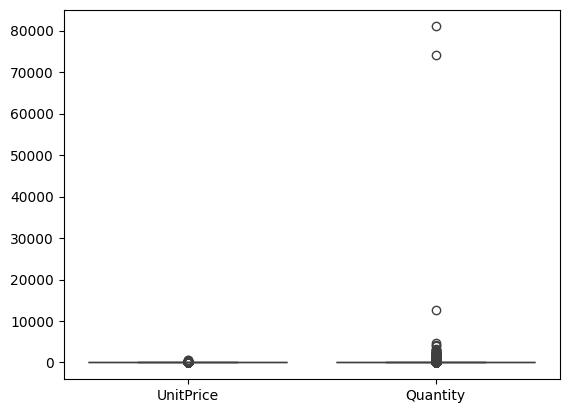

In [ ]:
bxplt = rel_transac[['UnitPrice', 'Quantity']]
sns.boxplot(data=bxplt)
plt.show()

In [ ]:
def handle_outliers(df, col):
    Q1 = df[col].quantile(0.25) # 25% quantile
    Q3 = df[col].quantile(0.75) # 75% quantile
    IQR = Q3 - Q1  #interquantile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df.loc[:, col] = df[col].clip(lower_bound, upper_bound)

    return df

In [ ]:
outliers_col = ['Quantity',
                'UnitPrice']
for col in outliers_col:
  final_df = handle_outliers(rel_transac, col)

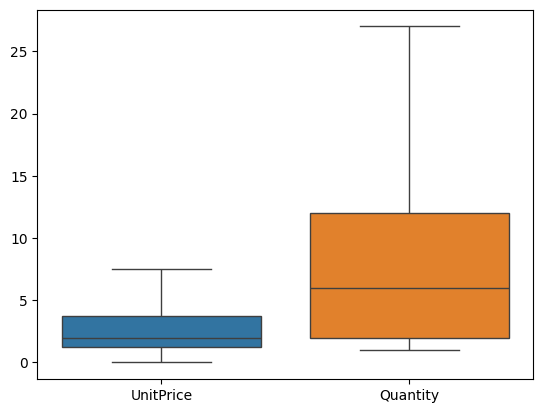

In [ ]:
bxplt = final_df[['UnitPrice', 'Quantity']]
sns.boxplot(data=bxplt)
plt.show()

In [ ]:
def create_column(df):
    invoice_date = pd.to_datetime(df['InvoiceDate'])
    df.loc[:, 'Month'] = invoice_date.dt.month_name()
    df.loc[:, 'DayOfWeek'] = invoice_date.dt.day_name()
    return df

In [ ]:
final_df = create_column(final_df)
final_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,DayOfWeek
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,7.50,16479.0,United Kingdom,November,Tuesday
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,May,Sunday
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,November,Monday


## Understanding new insights from the data (1 point)

1.  Are there any free items in the data? How many are there?

2.  Find the number of transactions per country and visualize using an appropriate plot

3.  What is the ratio of customers who are repeat purchasers vs single-time purchasers? Visualize using an appropriate plot.

4. Plot heatmap showing unit price per month and day of the week

  **Hint:** Month name as index on Y-axis, Day of the week on X-axis

5. Find the top 10 customers who bought the most no.of items. Also find the top 10 Items bought by most no.of customers.

In [ ]:
# free items
free_items = final_df[final_df['UnitPrice'] == 0]
print(f"There are {free_items.shape[0]} free items in the data.")

There are 31 free items in the data.


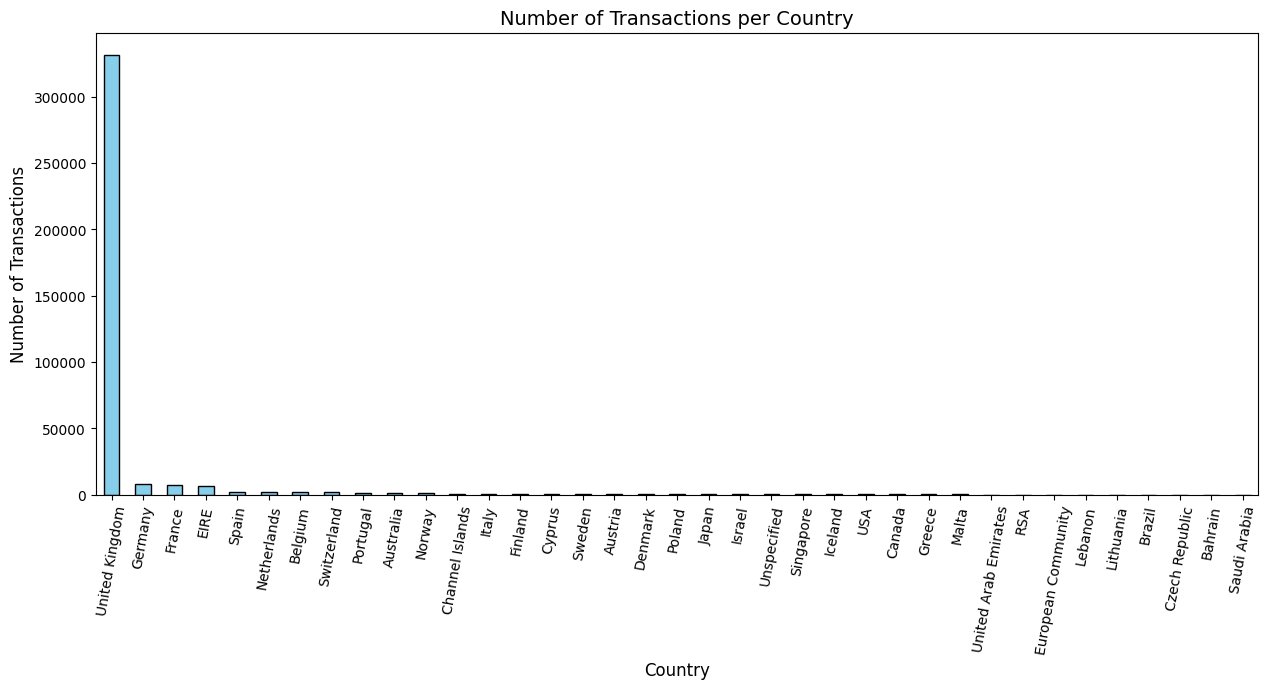

In [ ]:
# no. of transactions per country
#transac_per_country = final_df.groupby('Country')['InvoiceNo']
transactions_per_country = final_df['Country'].value_counts()

# Bar plot for transactions per country
plt.figure(figsize=(15, 6))
transactions_per_country.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Number of Transactions per Country', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=12)
plt.xticks(rotation=80)
plt.show()

{'Single-Time Purchasers': 80, 'Repeat Purchasers': 4253}


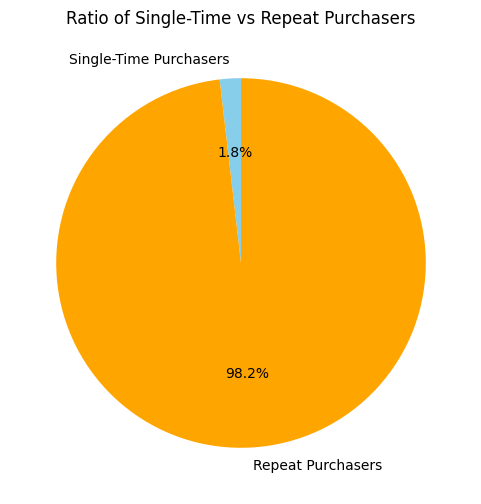

In [ ]:
# customer ratio repeat vs single time purchasers
customer_purchases = final_df.groupby('CustomerID')['InvoiceNo'].count()

repeat = (customer_purchases > 1).sum()
single_time = (customer_purchases == 1).sum()

# Calculate ratios
ratios = {'Single-Time Purchasers': single_time, 'Repeat Purchasers': repeat}
print(ratios)
# Visualize using a pie chart
plt.figure(figsize=(6, 6))
plt.pie(ratios.values(), labels=ratios.keys(), autopct='%1.1f%%', startangle=90, colors=['skyblue', 'orange'])
plt.title('Ratio of Single-Time vs Repeat Purchasers')
plt.show()

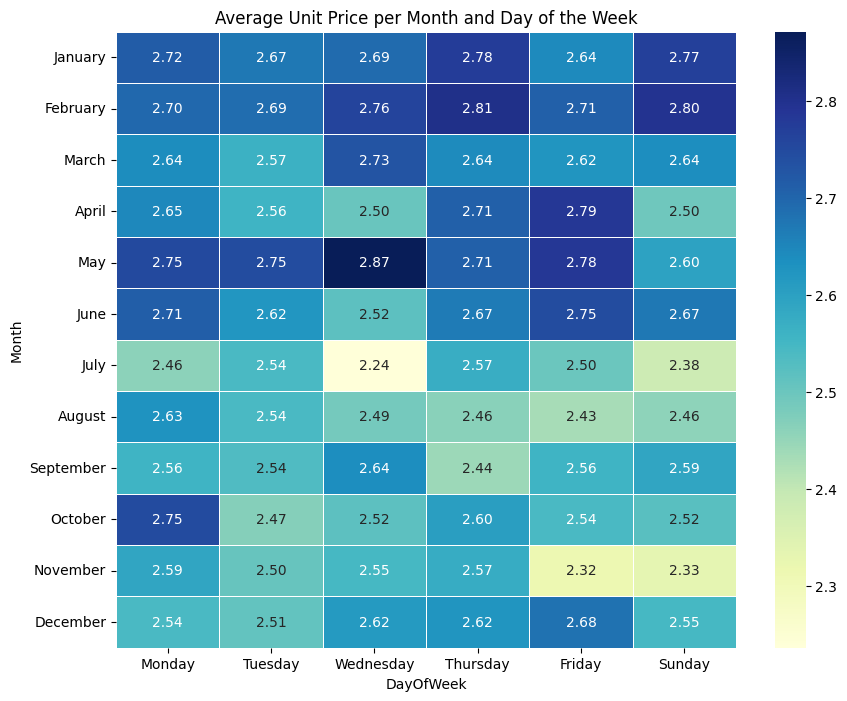

In [ ]:
# Visualize heatmap
# Aggregate data to calculate the mean UnitPrice
heatmap_data = final_df.pivot_table(
    values='UnitPrice',
    index='Month',  # Rows: Month Names
    columns='DayOfWeek',  # Columns: Days of the Week
    aggfunc='mean'
)
# months in order
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data.reindex(index=months)

# weekdays in order
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Sunday"]
heatmap_data = heatmap_data[weekdays]

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, fmt=".2f", linewidths=0.5)
plt.title('Average Unit Price per Month and Day of the Week')
plt.show()

In [ ]:
# Top 10 customers who bought the max. no. of items
top_customers = final_df.groupby('CustomerID')['Quantity'].sum().head(10).sort_values(ascending=False)
print("Top 10 custumers who bought the most no. of items:")
print(top_customers)

# Top 10 items by no. of unique customers
top_items = final_df.groupby('StockCode')['CustomerID'].nunique().head(10).sort_values(ascending=False)
print("Top 10 items bought by custumers:")
print(top_items)

Top 10 custumers who bought the most no. of items:
CustomerID
12347.0    2061
12356.0    1025
12348.0     680
12349.0     592
12352.0     526
12354.0     497
12350.0     196
12355.0      93
12346.0      27
12353.0      14
Name: Quantity, dtype: int64
Top 10 items bought by custumers:
StockCode
10133     98
10135     88
10125     48
11001     42
10002     39
10120     25
10080     17
10124A     5
10124G     4
10123C     3
Name: CustomerID, dtype: int64


## Feature Engineering and Transformation (2 points)

### Create new features to uncover better insights and drop the unwanted columns

* Create a new column which represents Total amount spent by each customer

    **Hint:** Quantity * UnitPrice

* Customer IDs are seen to be repeated. Maintain unique customer IDs by grouping and summing up all possible observations per customer.

    **Hint:** [pandas.groupby.agg](https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html)

**Note:** Perform the above operations in function, to reuse and apply the same for test data

In [42]:
def create_tot_amount(df):
    df.loc[:, 'TotalAmount'] = df['Quantity'] * df['UnitPrice']
    return df

In [43]:
# create total amount column
final_df = create_tot_amount(final_df)
final_df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Month,DayOfWeek,TotalAmount
0,579427,22636,CHILDS BREAKFAST SET CIRCUS PARADE,2,2011-11-29 13:04:00,7.50,16479.0,United Kingdom,November,Tuesday,15.00
1,554092,21916,SET 12 RETRO WHITE CHALK STICKS,24,2011-05-22 12:41:00,0.42,17176.0,United Kingdom,May,Sunday,10.08
2,577774,84692,BOX OF 24 COCKTAIL PARASOLS,6,2011-11-21 15:57:00,0.42,16712.0,United Kingdom,November,Monday,2.52


In [55]:
def customer_summary(df):
    customer_summary = df.groupby('CustomerID').agg({
        'InvoiceNo': 'nunique',
        'Quantity': 'sum',
        'TotalAmount': 'sum',
        'StockCode': 'nunique',
        'Country': 'unique',
        'Month': 'unique',
        'DayOfWeek': 'unique'
    }).reset_index()
    customer_summary.rename(columns={
        'InvoiceNo': 'TotalTransactions',
        'TotalAmount': 'TotalAmountSpent',
        'StockCode': 'TotalUniqueItems'
    }, inplace=True)
    return customer_summary


In [56]:
customer_summary = customer_summary(final_df)
customer_summary

,CustomerID,TotalTransactions,Quantity,TotalAmountSpent,TotalUniqueItems,Country,Month,DayOfWeek
0,12346.0,1,27,28.08,1,[United Kingdom],[January],[Tuesday]
1,12347.0,7,2061,3659.24,100,[Iceland],"[October, April, August, December, January, June]","[Monday, Thursday, Tuesday, Wednesday]"
2,12348.0,4,680,482.24,20,[Finland],"[December, January, April, September]","[Thursday, Tuesday, Sunday]"
3,12349.0,1,592,1232.51,67,[Italy],[November],[Monday]
4,12350.0,1,196,294.40,16,[Norway],[February],[Wednesday]
...,...,...,...,...,...,...,...,...
4328,18280.0,1,45,174.50,10,[United Kingdom],[March],[Monday]
4329,18281.0,1,54,61.92,7,[United Kingdom],[June],[Sunday]
4330,18282.0,2,80,137.46,11,[United Kingdom],"[December, August]",[Friday]
4331,18283.0,16,1291,1926.08,251,[United Kingdom],"[January, April, November, December, July, May...","[Thursday, Wednesday, Tuesday, Monday, Sunday]"


### Scale the data

Apply `StandardScaler` on the features.

In [58]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 371969 entries, 0 to 514812
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    371969 non-null  object 
 1   StockCode    371969 non-null  object 
 2   Description  371969 non-null  object 
 3   Quantity     371969 non-null  int64  
 4   InvoiceDate  371969 non-null  object 
 5   UnitPrice    371969 non-null  float64
 6   CustomerID   371969 non-null  float64
 7   Country      371969 non-null  object 
 8   Month        371969 non-null  object 
 9   DayOfWeek    371969 non-null  object 
 10  TotalAmount  371969 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 34.1+ MB


In [57]:
# YOUR CODE HERE for scaling
scale = StandardScaler()
scaled_data = scale.fit_transform(customer_summary[['TotalTransactions', 'Quantity', 'TotalAmountSpent', 'TotalUniqueItems']])
scaled_data

array([[-0.42448734, -0.39446171, -0.38409579, -0.70057446],
       [ 0.36350423,  0.76008964,  0.71159023,  0.492665  ],
       [-0.03049156, -0.02380191, -0.24705508, -0.47156891],
       ...,
       [-0.29315541, -0.36437753, -0.35109087, -0.58004523],
       [ 1.54549158,  0.3230176 ,  0.18861708,  2.31265652],
       [-0.16182349,  0.31847659,  0.05773499, -0.02561072]])

In [60]:
scaled_data[:,2]

array([-0.38409579,  0.71159023, -0.24705508, ..., -0.35109087,
        0.18861708,  0.05773499])

## Clustering ( 5 points)

### Apply k-means algorithm to identify a specific number of clusters


* Fit the k-means model

* Extract and store the cluster centroids

Below are the parameters for k-means, which are helpful

**n_clusters** is no. of clusters specified

**k-means++** is a random initialization method for centroids to avoid random initialisation trap

**max_iter** is max no of iterations defined when k-means is running

**n_init** is no. of times k-means will run with different initial centroids

[why-is-k-means-slower-than-random-initialization-k-means](https://stats.stackexchange.com/questions/185396/why-is-k-means-slower-than-random-initialization-k-means/185422)

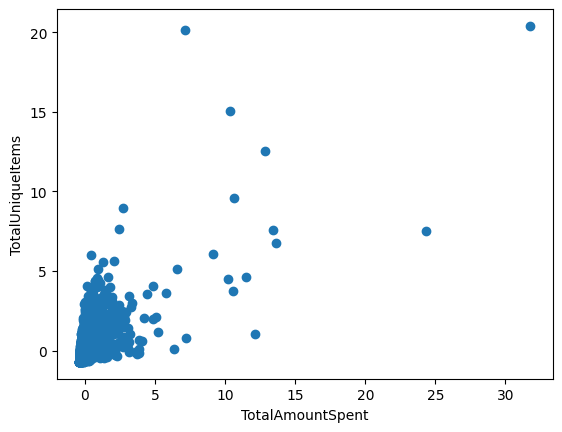

In [61]:
#visualize the data using 2 features
plt.scatter(scaled_data[:,2], scaled_data[:,3])
plt.xlabel('TotalAmountSpent')
plt.ylabel('TotalUniqueItems')
plt.show()

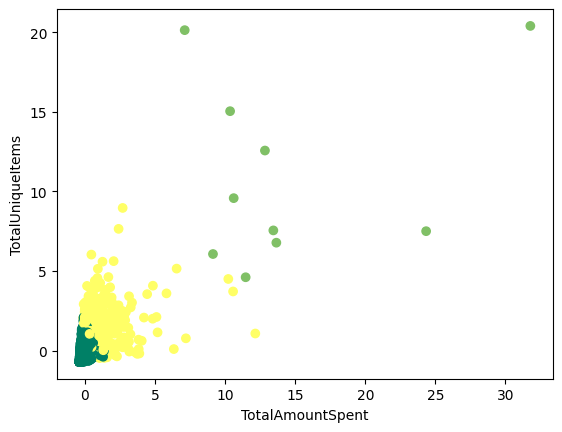

In [62]:

# YOUR CODE HERE to apply KMeans
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10 ,random_state=1)
y_predict = kmeans.fit_predict(scaled_data)
plt.scatter(scaled_data[:,2], scaled_data[:,3], c=y_predict, cmap = 'summer')
plt.xlabel('TotalAmountSpent')
plt.ylabel('TotalUniqueItems')
plt.show()

#### Find the optimal number of clusters (K) by using the [Elbow method](https://pythonprogramminglanguage.com/kmeans-elbow-method/).

Use the optimal no. of clusters and store the cluster centroids

In [ ]:
# YOUR CODE HERE

### Apply DBSCAN algorithm for clustering

- Compare the results of clusters from k-means and DBSCAN


In [ ]:
# YOUR CODE HERE

### Analyze the clusters


- consider two features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** 2D plot

- consider three features and visualize the clusters with different colors using the predicted cluster centers.

  **Hint:** [3D plot](https://matplotlib.org/stable/gallery/mplot3d/scatter3d.html
)

In [ ]:
# YOUR CODE HERE

### Train a supervised algorithm on clustered data

This will allow us to predict cluster numbers (label) for each test data instance

* Create labelled data with k-means cluster labels
  
  **Hint**: [`kmeans.labels_`](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
)
* Split the data into train and validation sets
* Train a supervised algorithm on the train data
* Find the accuracy of the model using validation data

In [ ]:
# YOUR CODE HERE

### Evaluation of Test Data
* Use the model to predict the labels for the Test data below
* Format the test data in the same format as the train data.
* Predict it with trained supervised ML model

In [ ]:
# Test set provided as below
test = pd.read_csv("Online_Retail_Test.csv")
test.head(3)

In [ ]:
# YOUR CODE HERE

### Report Analysis

- Discuss the pros and cons of removing the missing values vs replacing with the mean values
- Based on the visualization of clusters, comment on the difference in buying patterns of each cluster
- What other methods could be used to determine the optimal no. of clusters?